Dataset: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs

In [1]:
import pandas
import glob
import os
import cv2
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [2]:
# seeing the images and printing them
img = cv2.imread('data/train/1.jpg', cv2.IMREAD_COLOR) 
img = img / 255.0
img = img.astype(np.float32)
plt.imshow(img)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

In [ ]:
h, w, channels = img.shape
half = w//2
image = img[:, :half]
mask = img[:, half:]
print(image.shape)
print(mask.shape)

(256, 256, 3)
(256, 256, 3)


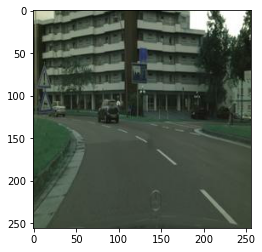

In [ ]:
plt.imshow(image)

In [4]:
plt.imshow(mask)

NameError: name 'mask' is not defined

In [82]:
if not os.path.isdir('data/train/images/'):
    os.mkdir('data/train/images/')
if not os.path.isdir('data/train/masks/'):
    os.mkdir('data/train/masks/')

if not os.path.isdir('data/val/images/'):
    os.mkdir('data/val/images/')
if not os.path.isdir('data/val/masks/'):
    os.mkdir('data/val/masks/')

In [5]:
# saving to a specific path
# cv2.imwrite(os.path.join(path , 'waka.jpg'), img)

def split_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR) 
    img = img / 255.0
    img = img.astype(np.float32)

    h, w, _ = img.shape
    half = w//2
    image = img[:, :half]
    mask = img[:, half:]

    return image, mask


folder_path = 'data/train'
for filename in os.listdir(folder_path):
    print(filename)
    if not os.path.isdir(os.path.join(folder_path, filename)):
        image, mask = split_image(os.path.join(folder_path, filename))
        cv2.imwrite(os.path.join(folder_path, 'images', filename), image*255)
        cv2.imwrite(os.path.join(folder_path, 'masks', filename), mask*255)
        os.remove(os.path.join(folder_path, filename))

folder_path = 'data/val'
for filename in os.listdir(folder_path):
    print(filename)
    if not os.path.isdir(os.path.join(folder_path, filename)):
        image, mask = split_image(os.path.join(folder_path, filename))
        cv2.imwrite(os.path.join(folder_path, 'images', filename), image*255)
        cv2.imwrite(os.path.join(folder_path, 'masks', filename), mask*255)
        os.remove(os.path.join(folder_path, filename))

images
masks
images
masks


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

images_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1./255.0,
)
masks_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1./255.0,
)

In [7]:
images_generator = images_datagen.flow_from_directory(
    'data/train/',
    # target_size=(256, 256),
    batch_size=32,
    classes=['images'],
    class_mode=None
)
masks_generator = masks_datagen.flow_from_directory(
    'data/train/',
    # target_size=(256, 256),
    batch_size=32,
    classes=['masks'],
    class_mode=None
)
train_generator = zip(images_generator, masks_generator)

val_images_generator = images_datagen.flow_from_directory(
    'data/val/',
    # target_size=(256, 256),
    batch_size=32,
    classes=['images'],
    class_mode=None
)
val_masks_generator = masks_datagen.flow_from_directory(
    'data/val/',
    # target_size=(256, 256),
    batch_size=32,
    classes=['masks'],
    class_mode=None
)
val_generator = zip(val_images_generator, val_masks_generator)

Found 2975 images belonging to 1 classes.
Found 2975 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.


(256, 256, 3)


/Users/rayaq/miniforge3/envs/ml/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/rayaq/miniforge3/envs/ml/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


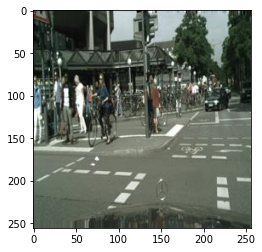

In [8]:
# testing to see if it is done correctly
for i in images_generator:
    for j in i:
        img = np.asarray(j)
        plt.imshow(img, cmap='gray')
        print(img.shape)
            
        break
    break

In [9]:
n_classes = 20

In [10]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2DTranspose, Concatenate
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


#Repeated convolutional blocks can be defined using a reusable function.
def conv_block(input,num_filters):
  x=Conv2D(num_filters,3, padding= 'same')(input)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  x=Conv2D(num_filters,3, padding= 'same')(input)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)
  
  return x


#Repeated encoder convolutional blocks can be defined using a reusable function.
def encoder_block(input, num_filters):
  x= conv_block(input, num_filters)
  p= MaxPool2D((2,2))(x)
  return x,p


#Repeated decoder blocks can be defined using a reusable function.
def decoder_block(input,skip_features, num_filters):
  x=Conv2DTranspose(num_filters,(2,2), strides=2, padding='same')(input)
  x=Concatenate()([x,skip_features])
  x=conv_block(x,num_filters=2)
  return x


#S is the output of the conv block --> P is the output of the max pooling --> d is the ouput of the decoder block
def unet_arch(input_shape):
  inputs= Input(input_shape)

  #Following the U-net Architecture 
  s1,p1 = encoder_block(inputs,64)
  s2,p2 = encoder_block(p1,128)
  s3,p3 = encoder_block(p2,256)
  s4,p4 = encoder_block(p3,512)

  b1 = conv_block(p4,1024)

  d1 = decoder_block(b1,s4,512)
  d2 = decoder_block(d1,s3,256)
  d3 = decoder_block(d2,s2,128)
  d4 = decoder_block(d3,s1,64)

  outputs=Conv2D(3,1, padding='same',activation ='sigmoid')(d4)
  
  model = Model(inputs, outputs, name='U-net')
  return model

In [11]:
model = unet_arch((256,256,3))
model.summary()
# plot_model(model, show_shapes=True)

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 64  256        ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.FalseNegatives()
    ]
)

In [13]:
model.fit(
    train_generator, 
    epochs=10,
    # validation_data=masks_generator,
    verbose=1,
    # callbacks=[DisplayCallback()]
)

Epoch 1/10


/Users/rayaq/miniforge3/envs/ml/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


     91/Unknown - 84s 914ms/step - loss: 0.7052 - binary_accuracy: 0.0479 - false_negatives: 372020000.0000

ValueError: `logits` and `labels` must have the same shape, received ((31, 256, 256, 3) vs (32, 256, 256, 3)).

In [146]:
im = cv2.imread('data/images/1.jpg')
pred = model.predict(im)
plt.imshow(pred)

ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>